In [1]:
import os
import sys
import numpy as np
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.parameter import Parameter

from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.preprocessing.label import LabelEncoder

from torch import Tensor, LongTensor
from torch.utils.data import DataLoader, Sampler
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, LambdaLR

from IPython.display import clear_output
%pylab inline

from slayer import SLayer
from src.sharedCode.provider import Provider
from src.sharedCode.experiments import *
from train_functions import *

Populating the interactive namespace from numpy and matplotlib


In [2]:
torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Tue Mar 19 01:23:15 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 415.25       Driver Version: 415.25       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce MX150       Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   65C    P5    N/A /  N/A |    802MiB /  2002MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
cuda_n = 0

In [5]:
class UpperDiagonalThresholdedLogTransform:
    def __init__(self, nu):
        self.b_1 = (torch.Tensor([1, 1]) / np.sqrt(2))
        self.b_2 = (torch.Tensor([-1, 1]) / np.sqrt(2))
        self.nu = nu

    def __call__(self, dgm):
        
        if dgm.ndimension() == 0:
            return dgm

        if dgm.is_cuda:
            self.b_1 = self.b_1.cuda()
            self.b_2 = self.b_2.cuda()

#         start_time = time.time()
        x = torch.mul(dgm, self.b_1.repeat(dgm.size(0), 1))
        x = torch.sum(x, 1)
        y = torch.mul(dgm, self.b_2.repeat(dgm.size(0), 1))
        y = torch.sum(y, 1)
        i = (y <= self.nu)
        y[i] = torch.log(y[i] / self.nu) + self.nu
        ret = torch.stack([x, y], 1)
#         print("upper diag threshold computation - {:.3f}s".format(time.time() - start_time))
        return ret


def pers_dgm_center_init(n_elements):
    centers = []
    while len(centers) < n_elements:
        x = np.random.rand(2)
        if x[1] > x[0]:
            centers.append(x.tolist())

    return torch.Tensor(centers)


class SLayerPHT(nn.Module):
    def __init__(self,
                 n_directions,
                 n_elements,
                 point_dim,
                 n_neighbor_directions=0,
                 center_init=None,
                 sharpness_init=None):
        super(SLayerPHT, self).__init__()

        self.n_directions = n_directions
        self.n_elements = n_elements
        self.point_dim = point_dim
        self.n_neighbor_directions = n_neighbor_directions

        self.slayers = [SLayer(n_elements, point_dim, center_init, sharpness_init)
                        for i in range(n_directions)]
        for i, l in enumerate(self.slayers):
            self.add_module('sl_{}'.format(i), l)

    def forward(self, input):
        assert len(input) == self.n_directions

        prepared_batches = None
        if all(SLayer.is_prepared_batch(b) for b in input):
            prepared_batches = input
        elif all(SLayer.is_list_of_tensors(b) for b in input):
            prepared_batches = [SLayer.prepare_batch(input_i, self.point_dim) for input_i in input]
        else:
            raise ValueError('Unrecognized input format! Expected list of Tensors or list of SLayer.prepare_batch outputs!')

        batch_size = prepared_batches[0][0].size()[0]
        assert all(prep_b[0].size()[0] == batch_size for prep_b in prepared_batches)

        output = []
        for i, sl in enumerate(self.slayers):
            i_th_output = []
            i_th_output.append(sl(prepared_batches[i]))

            for j in range(1, self.n_neighbor_directions + 1):
                i_th_output.append(sl(prepared_batches[i - j]))
                i_th_output.append(sl(prepared_batches[(i + j) % self.n_directions]))

            if self.n_directions > 0:
                i_th_output = torch.stack(i_th_output, 1)
            else:
                i_th_output = output[0]

            output.append(i_th_output)

        return output

    @property
    def is_gpu(self):
        return self.slayers[0].is_gpu

In [6]:
def _data_setup(params):
    view_name_template = 'dim_0_dir_{}'
    subscripted_views = sorted([view_name_template.format(i) for i in range(32)])
    assert (str(len(subscripted_views)) in params['data_path'])

    print('Loading provider...')
    dataset = Provider()
    dataset.read_from_h5(params['data_path'])

    assert all(view_name in dataset.view_names for view_name in subscripted_views)

    print('Create data loader...')
    data_train, data_test = train_test_from_dataset(dataset,
                                                    test_size=params['test_ratio'],
                                                    batch_size=params['batch_size'])

    return data_train, data_test, subscripted_views

In [7]:
class MyModel(torch.nn.Module):
    def __init__(self, subscripted_views):
        super(MyModel, self).__init__()
        self.subscripted_views = subscripted_views

        n_elements = 75
        n_filters = 16
        stage_2_out = 25
        n_neighbor_directions = 1

        self.transform = UpperDiagonalThresholdedLogTransform(0.1)

        self.pht_sl = SLayerPHT(len(subscripted_views),
                                n_elements,
                                2,
                                n_neighbor_directions=n_neighbor_directions,
                                center_init=self.transform(pers_dgm_center_init(n_elements)),
                                sharpness_init=torch.ones(n_elements, 2) * 4)

        self.stage_1 = []
        for i in range(len(subscripted_views)):
            seq = nn.Sequential()
            seq.add_module('conv_1', nn.Conv1d(1 + 2 * n_neighbor_directions, n_filters, 1, bias=False))
            seq.add_module('conv_2', nn.Conv1d(n_filters, 4, 1, bias=False))
            self.stage_1.append(seq)
            self.add_module('stage_1_{}'.format(i), seq)

        self.stage_2 = []
        for i in range(len(subscripted_views)):
            seq = nn.Sequential()
            seq.add_module('linear_1', nn.Linear(n_elements, stage_2_out))
            seq.add_module('batch_norm', nn.BatchNorm1d(stage_2_out))
            seq.add_module('linear_2'
                           , nn.Linear(stage_2_out, stage_2_out))
            seq.add_module('relu', nn.ReLU())
            seq.add_module('Dropout', nn.Dropout(0.4))

            self.stage_2.append(seq)
            self.add_module('stage_2_{}'.format(i), seq)

        linear_1 = nn.Sequential()
        linear_1.add_module('linear', nn.Linear(len(subscripted_views) * stage_2_out, 100))
        linear_1.add_module('batchnorm', torch.nn.BatchNorm1d(100))
        linear_1.add_module('drop_out', torch.nn.Dropout(0.3))
        self.linear_1 = linear_1

        linear_2 = nn.Sequential()
        linear_2.add_module('linear', nn.Linear(100, 70))

        self.linear_2 = linear_2

    def forward(self, batch):
        x = [batch[n] for n in self.subscripted_views]
        x = [[self.transform(dgm.cpu()).cuda() for dgm in view_batch] for view_batch in x]

        x = self.pht_sl(x)

        x = [l(xx) for l, xx in zip(self.stage_1, x)]

        x = [torch.squeeze(torch.max(xx, 1)[0]) for xx in x]

        x = [l(xx) for l, xx in zip(self.stage_2, x)]

        x = torch.cat(x, 1)
        x = self.linear_1(x)
        x = self.linear_2(x)
        return x

In [8]:
def train_one_epoch(model, optimizer, train_data, params, criterion, variable_created_by_model):
    
    # training
    train_loss = []
    train_preds = []
    train_targets = []
    model.train(True)
    for i, (batch_input, batch_target) in enumerate(train_data, start=1):
        
        # transform input to tensor
        batch_input, batch_target = data_typing(batch_input, batch_target, params)

        if not variable_created_by_model:
            batch_input = Variable(batch_input)
        batch_target = Variable(batch_target)
        
        start_time = time.time()
        optimizer.zero_grad()
        batch_output = model(batch_input)
        print("forward pass - {:3f}s".format(time.time() - start_time))
        loss = criterion(batch_output, batch_target)
        loss.backward()
        optimizer.step()
        
        train_loss.append(loss.item())
        train_preds.extend(list(compute_labels(batch_output)))
        train_targets.extend(list(batch_target.cpu().data.numpy()))
    
    return train_loss, train_preds, train_targets

In [9]:
def train(model, optimizer, train_data, val_data, params, metric=accuracy_score, criterion=nn.CrossEntropyLoss(), variable_created_by_model=True):
    
    mean_train_loss = []
    mean_val_loss = []
    mean_train_metric = []
    mean_val_metric = []

    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.5 ** (epoch // params["lr_ep_step"]))
    
    for epoch in range(params["epochs"]):
        epoch_start_time = time.time()
        
        scheduler.step()
        print("current lr = {}".format(scheduler.get_lr()[0]))
        
        start_time = time.time()
        train_loss, train_preds, train_targets = train_one_epoch(
            model, optimizer, train_data, params, criterion, variable_created_by_model)
        print("train epoch - {:.3f}s".format(time.time() - start_time))
        start_time = time.time()
        val_loss, val_preds, val_targets = validate(
            model, val_data, params, criterion, variable_created_by_model)
        print("validate - {:3f}s".format(time.time() - start_time))

        # print the results for this epoch:
        mean_train_loss.append(np.mean(train_loss))
        mean_val_loss.append(np.mean(val_loss))
        mean_train_metric.append(metric(train_targets, train_preds))
        mean_val_metric.append(metric(val_targets, val_preds))
        
        clear_output(True)
        plt.figure(figsize=(10, 5))
        plt.subplot(121)
        plt.plot(mean_train_loss)
        plt.plot(mean_val_loss)
        plt.subplot(122)
        plt.plot(mean_train_metric)
        plt.plot(mean_val_metric)
        plt.gca().set_ylim([0, 1])
        plt.show()
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, params["epochs"], time.time() - epoch_start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(mean_train_loss[-1]))
        print("  validation loss: \t\t\t{:.6f}".format(mean_val_loss[-1]))
        print("  training metric: \t\t\t{:.2f}".format(mean_train_metric[-1]))
        print("  validation metric: \t\t\t{:.2f}".format(mean_val_metric[-1]))
        
#         if mean_train_loss[-1] < epsilon:
#             break

    return mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric

# ? def cross_val_trains

In [10]:
def check_scheduler(optimizer, params):
    scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.5 ** (epoch // params["lr_ep_step"]))
    for epoch in range(params["epochs"]):
        scheduler.step()
        print(epoch, scheduler.get_lr()[0])

In [10]:
import os

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if directory != "" and not os.path.exists(directory):
        os.makedirs(directory)
        
def save_res(res, path):
    ensure_dir(path)
    with open(path, "w") as f:
        f.write(str(res))
        
def load_res(path):
    with open(path) as f:
        res = f.read()
    return eval(res)

def load_results(problem):
    train_loss_l = load_res("results/" + problem + "/train_loss")
    val_loss_l = load_res("results/" + problem + "/val_loss")
    train_metric_l = load_res("results/" + problem + "/train_auc")
    val_metric_l = load_res("results/" + problem + "/val_auc")
    return train_loss_l, val_loss_l, train_metric_l, val_metric_l
    
def save_results(problem, train_loss_l, val_loss_l, train_metric_l, val_metric_l):
    save_res(train_loss_l, "results/" + problem + "/" + "train_loss")
    save_res(val_loss_l, "results/" + problem + "/" + "val_loss")
    save_res(train_metric_l, "results/" + problem + "/" + "train_auc")
    save_res(val_metric_l, "results/" + problem + "/" + "val_auc")
    print("saved.")

In [11]:
def create_model(subscripted_views, params):
    print('Create model...')
    model = MyModel(subscripted_views)
    if params["cuda"]:
        model.cuda(params["cuda_device_id"])

    print("Create optimizer...")
    optimizer = optim.SGD(model.parameters(),
                          lr=params['lr_start'],
                          momentum=params['momentum'])
    
    return model, optimizer

In [12]:
def cross_val_train(problem, dataset, subscripted_views, cv, params, load=True, wanted_views=None):
    """
    Perform training and validation on each fold and save the result. 
    """

    sample_labels = list(dataset.sample_labels)
    label_encoder = LabelEncoder().fit(sample_labels)
    sample_labels = label_encoder.transform(sample_labels)

    label_map = lambda l: int(label_encoder.transform([l])[0])
    collate_fn = PersistenceDiagramProviderCollate(dataset, label_map=label_map, wanted_views=wanted_views)
    
    cv_splits = list(cv.split([0] * len(sample_labels), sample_labels))
    
    if load:
        train_loss_l, val_loss_l, train_metric_l, val_metric_l = load_results(problem)
        test_metric = list(map(lambda x: x[-1], val_metric_l))
        print("test metric mean:", np.mean(test_metric))
        print("test metric std:", np.std(test_metric))
        print(list(map(lambda x: np.round(x, 2), test_metric)))
    else:
        train_loss_l, val_loss_l, train_metric_l, val_metric_l, test_metric = [], [], [], [], []

    for i in range(len(test_metric), len(cv_splits)):
        
        train_i, test_i = cv_splits[i]
        
        train_data = DataLoader(dataset,
                                batch_size=params["batch_size"],
                                collate_fn=collate_fn,
                                shuffle=False,
                                sampler=SubsetRandomSampler(train_i.tolist()))

        val_data = DataLoader(dataset,
                               batch_size=params["batch_size"],
                               collate_fn=collate_fn,
                               shuffle=False,
                               sampler=SubsetRandomSampler(test_i.tolist()))

        model, optimizer = create_model(subscripted_views, params)
        mean_train_loss, mean_val_loss, mean_train_metric, mean_val_metric = train(
            model, optimizer, train_data, val_data, params, metric=accuracy_score, 
            criterion=nn.CrossEntropyLoss(), variable_created_by_model=True)

        train_loss_l.append(mean_train_loss)
        val_loss_l.append(mean_val_loss)
        train_metric_l.append(mean_train_metric)
        val_metric_l.append(mean_val_metric)
        test_metric.append(mean_val_metric[-1])

        save_results(problem, train_loss_l, val_loss_l, train_metric_l, val_metric_l)

    print("test metric mean:", np.mean(test_metric))
    print("test metric std:", np.std(test_metric)) 
    
    return test_metric

## mpeg7 experiment results

In [16]:
data_path = "data/npht_mpeg7_32dirs.h5"

print('Loading data...')

params = {
        'data_path': None,
        'epochs': 200,
        'momentum': 0.7,
        'lr_start': 0.1,
        'lr_ep_step': 20,
        'lr_adaption': 0.5,
        'n_splits' : 5,
        'batch_size': 32,
        'cuda': False,
        'cuda_device_id' : cuda_n,
    }

params['data_path'] = data_path

if torch.cuda.is_available():
    print("True")
    params['cuda'] = True
    torch.cuda.set_device(params["cuda_device_id"])

view_name_template = 'dim_0_dir_{}'
subscripted_views = sorted([view_name_template.format(i) for i in range(32)])

print('Loading provider...')
dataset = Provider()
dataset.read_from_h5(params['data_path'])

assert all(view_name in dataset.view_names for view_name in subscripted_views)

cv = StratifiedKFold(n_splits=params["n_splits"])
problem = "mpeg7"

Loading data...
True
Loading provider...


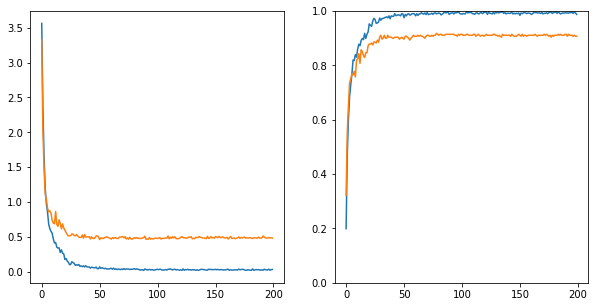

Epoch 200 of 200 took 34.916s
  training loss (in-iteration): 	0.036187
  validation loss: 			0.486523
  training metric: 			0.99
  validation metric: 			0.91
saved.
test metric mean: 0.9114285714285714
test metric std: 0.012453996981544774


[0.8964285714285715,
 0.9321428571428572,
 0.9035714285714286,
 0.9178571428571428,
 0.9071428571428571]

In [17]:
cross_val_train(problem, dataset, subscripted_views, cv, params, load=True)